In [291]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
from pymultifracs.viz import plot_psd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


## 1. Signal generation

In [93]:
# 1. Pure oscillations (no modulation, no noise)
pure = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.0,
    c2=0.0
)

# 2. MRW-modulated oscillations (no noise)
mrw_modulated = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

# 3. MRW + FBM noise (most realistic)
mrw_with_fbm = generate_synthetic_neural_signal(
    add_fbm_noise=True,
    add_powerline=False,
    c1=0.7,
    c2=-0.04,
    H=0.98  # Hurst exponent for FBM
)


Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

## 2. Signal exploration

In [94]:
mod  = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

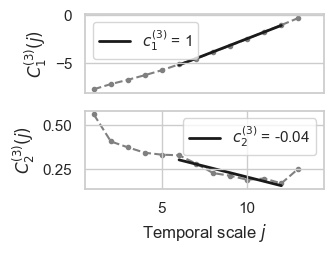

In [96]:
pwt = mfa(wavelet_analysis(mod["modulator"], 'db2').integrate(1).get_leaders(3), [(6, 12)])
pwt.cumulants.plot()

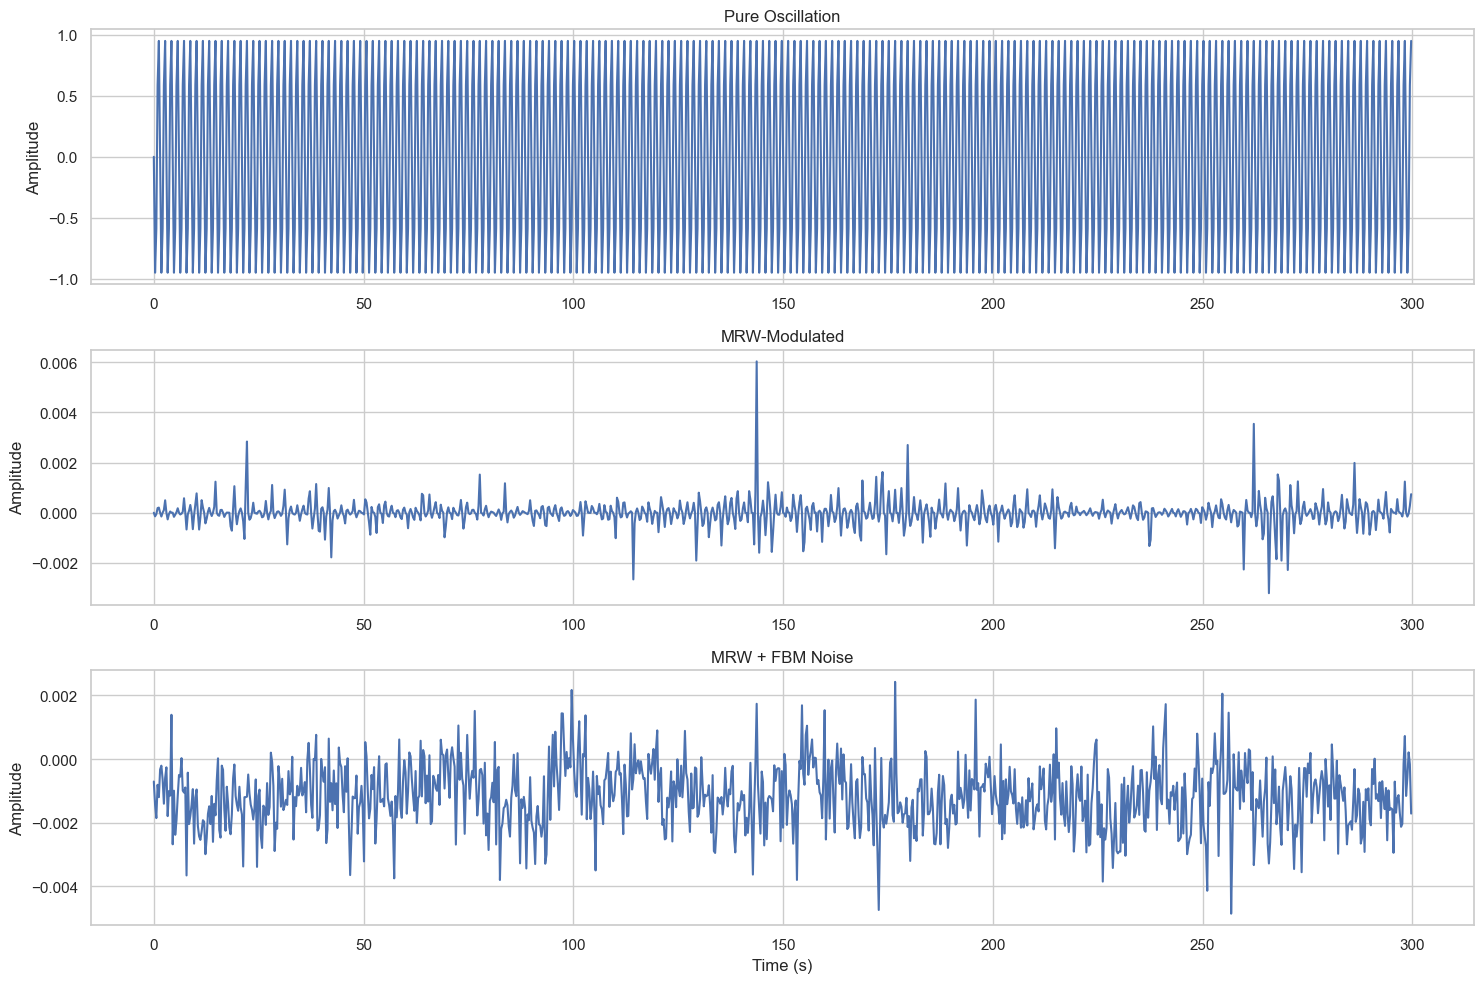

In [261]:
# Prepare data
signal_dicts = [pure, mrw_modulated, mrw_with_fbm]
titles = ["Pure Oscillation", "MRW-Modulated", "MRW + FBM Noise"]

fs = 250  # Sampling frequency
duration = 300
max_points = 1000


n_samples_to_plot = int(fs * duration)
t_full = signal_dicts[0]['time'][:n_samples_to_plot]


# Downsampling step
step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1
t = t_full[::step]

# Plot
plt.figure(figsize=(15, 10))

for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
    y_full = signal_dict['final_signal'][:n_samples_to_plot]
    y = y_full[::step]
    plt.subplot(len(signal_dicts), 1, i + 1)
    plt.plot(t, y)
    plt.title(title)
    plt.ylabel("Amplitude")
    if i == len(signal_dicts) - 1:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

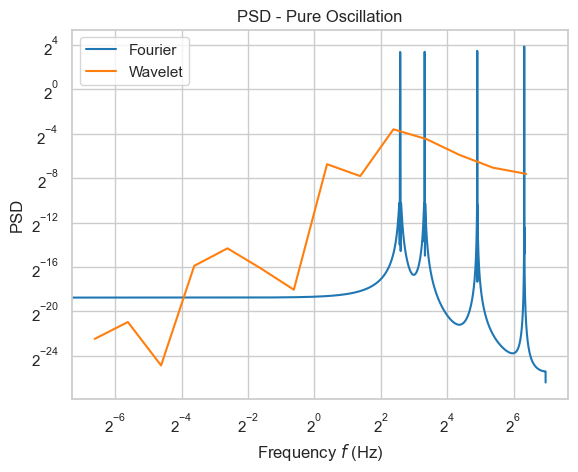

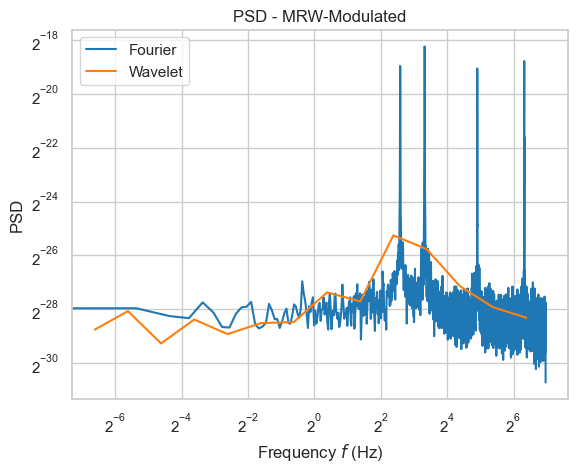

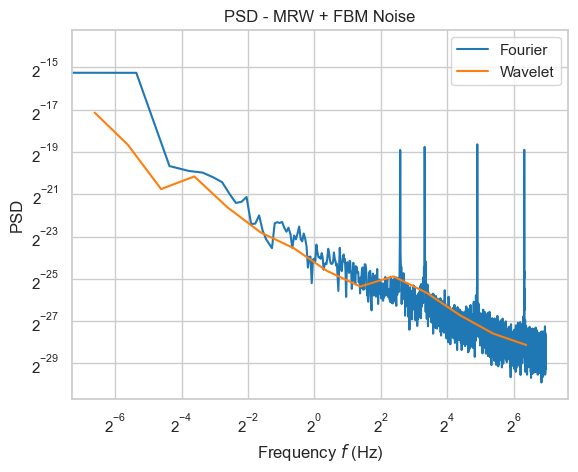

In [45]:
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]

for signal, title in zip(signal_list, titles):
    plot_psd(signal, fs=fs)
    plt.title(f"PSD - {title}")
    plt.show()

## 3. Signal decomposition

### VMD Benchmark hyperparameters

In [ ]:
def peak_frequency(mode, fs):
    f, Pxx = periodogram(mode, fs=fs)
    if len(Pxx) == 0:
        return 0
    return f[np.argmax(Pxx)]

def test_vmd_params(signal, fs, param_grid, expected_freqs, tolerance=2.0):
    records = []

    for params in param_grid:
        Nmodes = params.get('Nmodes', 5)

        IMFs, _, _ = VMD(signal,
                         params['alpha'],
                         params['tau'],
                         Nmodes,
                         params['DC'],
                         params['init'],
                         params['tol'])

        peak_freqs = [peak_frequency(mode, fs) for mode in IMFs]

        all_covered = all(
            any(abs(pf - ef) <= tolerance for pf in peak_freqs) 
            for ef in expected_freqs
        )

        peak_freqs_str = ', '.join(f"{pf:.2f}" for pf in peak_freqs)

        record = {
            'Nmodes': Nmodes,
            'alpha': params['alpha'],
            'tau': params['tau'],
            'DC': params['DC'],
            'init': params['init'],
            'tol': params['tol'],
            'peak_frequencies': peak_freqs_str,
            'all_covered': all_covered
        }
        records.append(record)

    df = pd.DataFrame(records)
    good_df = df[df['all_covered']].copy()
    return df, good_df

# Define your parameters
param_grid = []
alphas = [50, 200, 500, 1500]
taus = [0, 1]  
tols = [1e-5, 1e-7]    
inits = [0, 1]
DCs = [0, 1] 
Nmodes_list = [5]


for Nm in Nmodes_list:
    for alpha in alphas:
        for tau in taus:
            for DC in DCs:
                for init in inits:
                    for tol in tols:
                        param_grid.append({
                            'Nmodes': Nm,
                            'alpha': alpha,
                            'tau': tau,
                            'DC': DC,
                            'init': init,
                            'tol': tol
                        })

# Loop over signals but only run test on 'mrw_with_fbm'
all_results = []

for signal, name in zip(signal_list, signal_names):
    if name != 'mrw_modulated':
        print(f"Skipping signal: {name}")
        continue  # skip other signals

    print(f"\n--------------- Testing VMD params on signal: {name} -------------------")
    df_all, df_good = test_vmd_params(signal, fs, param_grid, expected_freqs)

    print(f"All tested parameters for signal '{name}':")

    df_all['signal'] = name
    all_results.append(df_all)

# Combine results if needed
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
else:
    print("No results collected.")


In [180]:
pd.set_option('display.max_rows', 500)
final_df[(final_df["all_covered"] == True) & (final_df["signal"] == "mrw_modulated")]

,Nmodes,alpha,tau,DC,init,tol,peak_frequencies,all_covered,signal
20,5,200,0,1,0,1.000000e-05,"6.00, 30.00, 10.00, 80.00, 106.84",True,mrw_modulated
21,5,200,0,1,0,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
22,5,200,0,1,1,1.000000e-05,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
23,5,200,0,1,1,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
28,5,200,1,1,0,1.000000e-05,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
29,5,200,1,1,0,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
30,5,200,1,1,1,1.000000e-05,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
31,5,200,1,1,1,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 113.26",True,mrw_modulated
32,5,500,0,0,0,1.000000e-05,"6.00, 10.00, 30.00, 53.77, 80.00",True,mrw_modulated
33,5,500,0,0,0,1.000000e-07,"6.00, 10.00, 30.00, 57.35, 80.00",True,mrw_modulated


In [168]:
# Convert peak frequencies strings back to list of floats
def parse_peak_freqs(s):
    return [float(x) for x in s.split(", ")]

final_df['peak_freqs_list'] = final_df['peak_frequencies'].apply(parse_peak_freqs)

# Compute mean absolute error between expected and detected peak frequencies
expected = np.array(expected_freqs)

def mean_abs_error(row):
    detected = np.array(row['peak_freqs_list'])
    # For each expected freq find closest detected freq
    errors = [np.min(np.abs(detected - ef)) for ef in expected]
    return np.mean(errors)

final_df['mean_abs_error'] = final_df.apply(mean_abs_error, axis=1)

# Sort by:
# 1) smallest tol (strictness)
# 2) all_covered == True (filter first)
# 3) smallest mean_abs_error
# 4) smallest Nmodes
df_best = final_df[final_df['all_covered']].copy()
df_best = df_best.sort_values(by=['tol', 'mean_abs_error', 'Nmodes'])

df_best.head(10)

,Nmodes,alpha,tau,DC,init,tol,peak_frequencies,all_covered,signal,peak_freqs_list,mean_abs_error
3,5,50,0,0,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
5,5,50,0,1,0,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
7,5,50,0,1,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
11,5,50,1,0,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
13,5,50,1,1,0,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
15,5,50,1,1,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
21,5,200,0,1,0,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 80.00",True,pure,"[6.0, 30.0, 10.0, 80.0, 80.0]",0.0
23,5,200,0,1,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0
29,5,200,1,1,0,1.000000e-07,"6.00, 30.00, 10.00, 80.00, 80.00",True,pure,"[6.0, 30.0, 10.0, 80.0, 80.0]",0.0
31,5,200,1,1,1,1.000000e-07,"6.00, 30.00, 80.00, 80.00, 10.00",True,pure,"[6.0, 30.0, 80.0, 80.0, 10.0]",0.0


### Set Parameters:

In [264]:
output_base = "../results/synthetic"
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

# PARAMETERS
fs = 250  # Hz
duration = 300.0       # Duration to plot (in seconds)
max_points = 1000      # Optional: downsample to this number of points

### Run the Decompositions:

In [1]:
# Run the decomposition
max_imfs = 8
max_modes = 8

best_vmd_params = {
    'pure': {'vmd_alpha': 50, 'vmd_tau': 0, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-5, 'Nmodes': 5},
    'mrw_modulated': {'vmd_alpha': 500, 'vmd_tau': 1, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 5},
    'mrw_with_fbm': {'vmd_alpha': 50, 'vmd_tau': 0, 'vmd_DC': 0, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 5},
}

methods = [
        "EMD",
        "VMD"
        #"VMDtransformer"
        ]

for signal, name in zip(signal_list, signal_names):
    print(f"--- Decomposition for: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    params = best_vmd_params.get(name, {})
    
    modes_dict = run_all_decompositions(
        signal_in=signal,
        methods=methods,
        Fs=fs,
        Nmodes=params.get('Nmodes', n_modes),
        MaxEmdIMF=max_imfs,
        MaxVmdModes=max_modes,
        vmd_alpha=params.get('vmd_alpha', 50),
        vmd_tau=params.get('vmd_tau', 0),
        vmd_DC=params.get('vmd_DC', 0),
        vmd_init=params.get('vmd_init', 0),
        vmd_tol=params.get('vmd_tol', 1e-7),
        return_modes=True
    )

    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        # Save only modes here
        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        print(f"Saved modes for {method} of {name}")


NameError: name 'signal_list' is not defined

In [ ]:
# Extract the features
for name in signal_names:
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")
        os.makedirs(os.path.dirname(features_path), exist_ok=True)

        compute_features_from_modes_and_save(modes_path, features_path, fs)


Features saved to ../results/synthetic/pure/EMD/features/pure_features.csv
Features saved to ../results/synthetic/pure/VMD/features/pure_features.csv
Features saved to ../results/synthetic/mrw_modulated/EMD/features/mrw_modulated_features.csv
Features saved to ../results/synthetic/mrw_modulated/VMD/features/mrw_modulated_features.csv
Features saved to ../results/synthetic/mrw_with_fbm/EMD/features/mrw_with_fbm_features.csv
Features saved to ../results/synthetic/mrw_with_fbm/VMD/features/mrw_with_fbm_features.csv


In [ ]:
# Generate the plots
for signal, name in zip(signal_list, signal_names):
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=0,
            output_dir=output_dir,
            duration=300,
            max_points=1000,
            spectrum_method='windowed_fft'  # choose 'psd', 'fft', or 'windowed_fft' here
        )


### Summarize the Results:

In [278]:
report_df = summarize_decomposition_results(
    signal_list=signal_list,          # list of signals you processed
    signal_names=signal_names,        # corresponding names
    sfreq=250,                        # your sampling frequency
    base_dir="../results/synthetic",     # change if you're saving somewhere else
    n_modes_to_use=None                  # how many modes to use in partial reconstruction
)


In [279]:
#report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False, mode="a" )
report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False )

In [280]:
report_df[report_df["Method"].isin(["EMD","VMD"])].head(100)


,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First N Modes),Number of Extracted Modes,AM,BM,Entropy,Centroid,Power Spectrum Sum,Skewness,Kurtosis,Hjorth Mobility,Hjorth Complexity
0,EMD,pure,0,80.000000,2.561758e-40,2.561758e-40,9,0.672676,43089.125881,2.846165,77.099625,172.356504,5.947941e-06,-1.752239,1.653813,1.020324
1,EMD,pure,1,30.000000,2.561758e-40,2.561758e-40,9,0.605774,37834.963826,3.821910,30.018115,151.339855,1.683074e-05,-1.487496,0.736922,1.003016
2,EMD,pure,2,10.000000,2.561758e-40,2.561758e-40,9,0.802420,72236.613702,4.172929,9.187075,288.946455,1.055302e-05,-1.006098,0.233950,1.044097
3,EMD,pure,3,6.000000,2.561758e-40,2.561758e-40,9,0.260894,6978.815627,3.379203,6.037482,27.915262,-1.834097e-04,-1.413563,0.150743,1.013700
4,EMD,pure,4,2.000000,2.561758e-40,2.561758e-40,9,0.046288,219.273285,3.240308,2.064081,0.877093,-9.360187e-04,-1.346368,0.050348,1.004038
5,EMD,pure,5,0.096970,2.561758e-40,2.561758e-40,9,0.003116,9.501119,1.100857,0.294200,0.038003,-1.130263e-01,17.297851,0.007861,2.250546
6,EMD,pure,6,0.100000,2.561758e-40,2.561758e-40,9,0.006704,21.874675,1.819190,0.149034,0.087061,-2.933613e-01,6.170811,0.003066,1.670075
7,EMD,pure,7,0.063636,2.561758e-40,2.561758e-40,9,0.005070,9.387277,2.319862,0.108303,0.037528,2.522658e-01,4.423603,0.001814,0.901312
8,EMD,pure,8,0.012121,2.561758e-40,2.561758e-40,9,0.002543,2.114834,2.468890,0.072277,0.008238,1.360199e+00,3.589539,0.000728,1.209830
9,EMD,mrw_modulated,0,80.000000,4.375405e-36,4.375405e-36,9,0.000419,0.021441,3.531499,80.702674,0.000086,-4.534960e-03,0.447034,1.667782,1.056073


| # | Feature               | Code Label  | Description                                                                 |
|---|-----------------------|-------------|-----------------------------------------------------------------------------|
| 1 | Spectral Entropy      | `ent`       | Measures complexity of frequency content — high entropy = noisy modes       |
| 2 | Spectral Power        | `Pfreq`     | Total energy in the mode's spectrum — higher means more meaningful signal   |
| 3 | Peak Frequency (Hz)   | `Ppeak`     | Frequency with maximum power — indicates which rhythm is captured           |
| 4 | Hjorth Mobility       | `Hmob`      | Indicates dominant frequency — higher means faster oscillations             |
| 5 | Hjorth Complexity     | `Hcomp`     | Describes structural irregularity — high = more complex or unstable signal  |


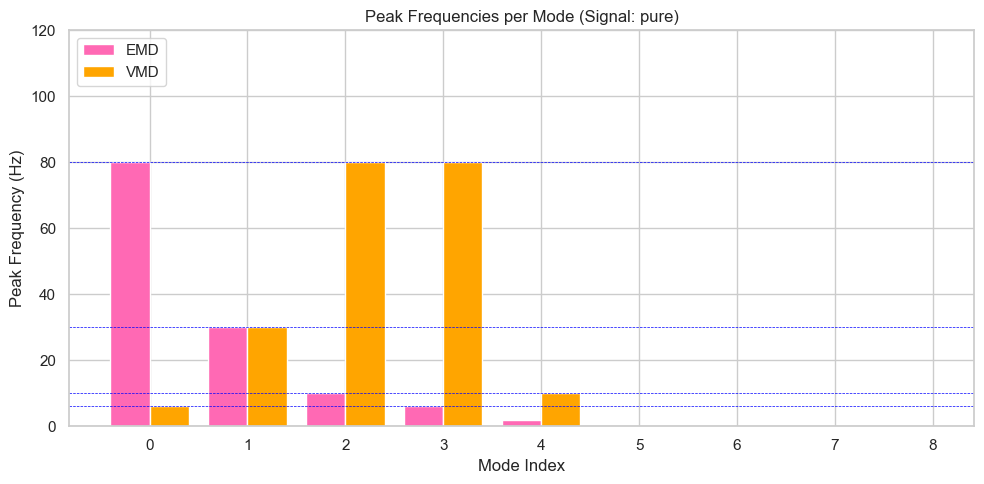

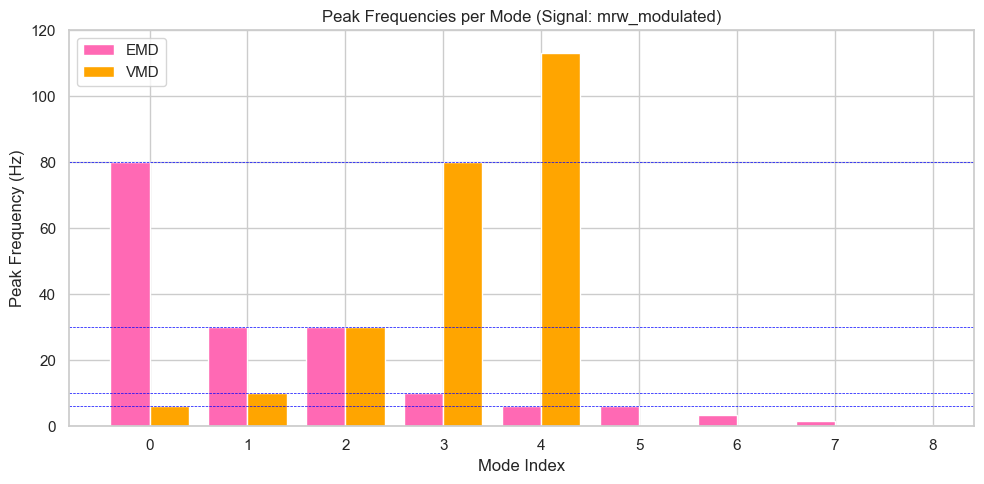

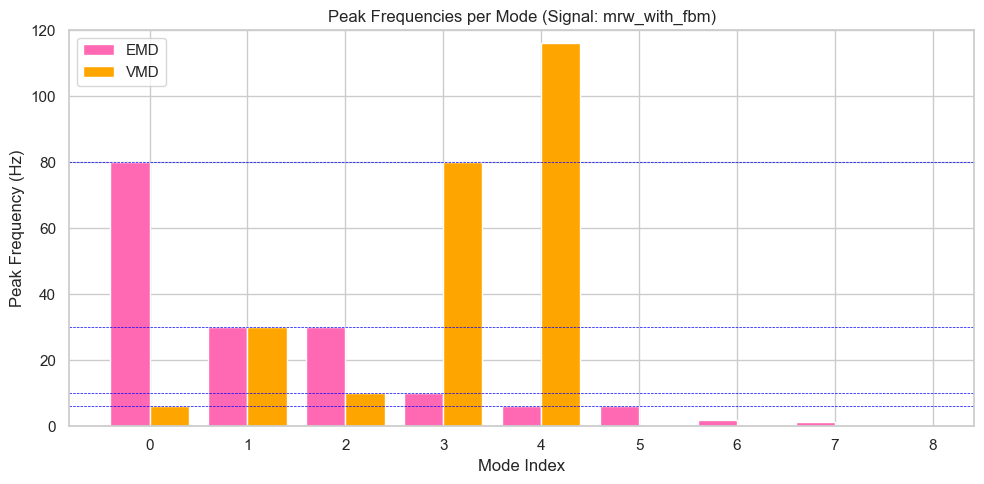

In [281]:
colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

signals = report_df["Signal"].unique()
for signal in signals:
    df_sig = report_df[report_df["Signal"] == signal].copy()

    # Align bars: group by mode index and pivot so that EMD and VMD are columns
    pivot_df = df_sig.pivot(index="Mode Index", columns="Method", values="Peak Frequency (Hz)").reset_index()
    pivot_df = pivot_df.sort_values("Mode Index")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.4  # width of bars
    x = pivot_df["Mode Index"]

    ax.bar(x - width/2, pivot_df["EMD"], width=width, label="EMD", color=colors["EMD"])
    ax.bar(x + width/2, pivot_df["VMD"], width=width, label="VMD", color=colors["VMD"])

    # Add horizontal lines for target frequencies
    for freq in [6, 10, 30, 80]:
        ax.axhline(freq, linestyle="--", color="blue", linewidth=0.5)

    ax.set_title(f"Peak Frequencies per Mode (Signal: {signal})")
    ax.set_xlabel("Mode Index")
    ax.set_ylabel("Peak Frequency (Hz)")
    ax.set_ylim(0, 120)
    ax.set_xticks(x)
    ax.legend()
    plt.tight_layout()
    plt.show()


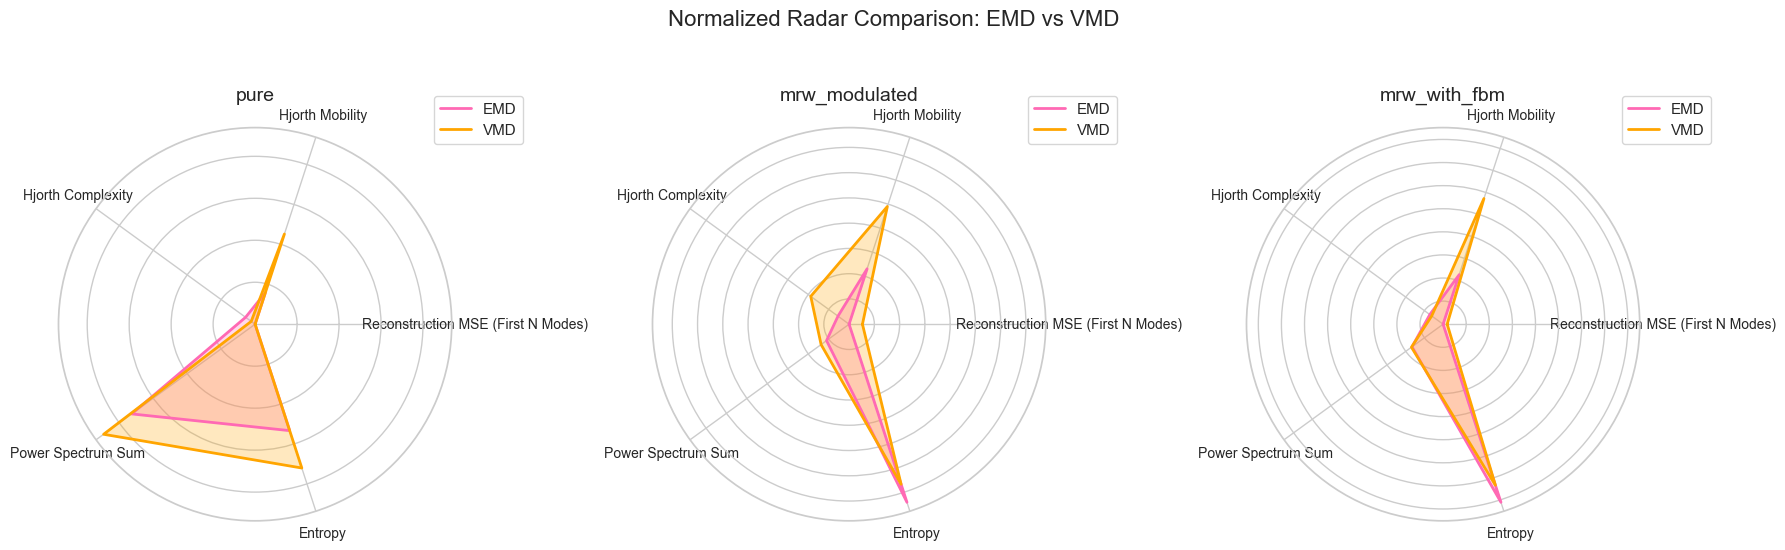

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select relevant features for radar plot
radar_features = [
    "Reconstruction MSE (First N Modes)",
    "Hjorth Mobility",
    "Hjorth Complexity",
    "Power Spectrum Sum",
    "Entropy"
]

# Copy df to avoid modifying original
df_plot = report_df.copy()

# Normalize selected features to [0,1]
df_plot["Power Spectrum Sum"] = np.log10(report_df["Power Spectrum Sum"] + 1e-10)
scaler = MinMaxScaler()
df_plot[radar_features] = scaler.fit_transform(df_plot[radar_features])

# Invert MSE so higher is better (1 - normalized MSE)
#df_plot["Reconstruction MSE (First N Modes)"] = 1 - df_plot["Reconstruction MSE (First N Modes)"]


# Plot setup
signals = df_plot["Signal"].unique()
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]  # close the loop

colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

fig, axs = plt.subplots(1, len(signals), figsize=(18, 6), subplot_kw=dict(polar=True))

for i, signal in enumerate(signals):
    ax = axs[i]
    for method in ["EMD", "VMD"]:
        subset = df_plot[(df_plot["Signal"] == signal) & (df_plot["Method"] == method)]
        if not subset.empty:
            values = subset[radar_features].mean().tolist()
            values += values[:1]  # close the radar plot
            ax.plot(angles, values, label=method, color=colors[method], linewidth=2)
            ax.fill(angles, values, color=colors[method], alpha=0.25)

    ax.set_title(signal, size=14, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, fontsize=10)
    ax.set_yticklabels([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.suptitle("Normalized Radar Comparison: EMD vs VMD", fontsize=16)
plt.tight_layout()
plt.savefig("radar_horizontal_emd_vmd.png", dpi=300)
plt.show()


### 📊 Scientific Comparison: EMD vs VMD on 3 Signal Types

| **Signal Type**     | **Metric**           | **VMD vs EMD** | **Scientific Interpretation**                                                                 |
|---------------------|----------------------|----------------|----------------------------------------------------------------------------------------------|
| **pure**            | Hjorth Mobility      | ↑ VMD          | VMD captures richer frequency content (more dynamic modes)                                  |
|                     | Hjorth Complexity    | ↓ VMD          | VMD extracts simpler, less convoluted modes                                                  |
|                     | Entropy              | ↑ VMD          | Slightly more spread-out frequency components; may reflect uniformity, not noise            |
|                     | **Conclusion**       | ✅ VMD better   | Better frequency representation and cleaner structure                                        |
| **mrw_modulated**   | Hjorth Mobility      | ↑↑ VMD         | Strong improvement — VMD captures frequency modulation effectively                          |
|                     | Hjorth Complexity    | ↓ VMD          | Simpler decomposition suggests better mode separation                                        |
|                     | Entropy              | ↓ VMD          | Indicates cleaner and more ordered modes                                                     |
|                     | **Conclusion**       | ✅✅ VMD much better | VMD excels on modulated multifractal signals                                                 |
| **mrw_with_fbm**    | Hjorth Mobility      | ↑ VMD          | Even on complex noise-like data, VMD captures diverse frequency features                    |
|                     | Hjorth Complexity    | ↓ VMD          | VMD provides more structured modes                                                           |
|                     | Entropy              | ↓ VMD          | Less randomness → better decomposition quality                                               |
|                     | **Conclusion**       | ✅ VMD better   | VMD handles complex, irregular signals with cleaner outputs                                 |



## 3. Apply the MFA:

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Processing signal: mrw_modulated


/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_49278/2093096099.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if name is not "pure":


<Figure size 800x400 with 0 Axes>

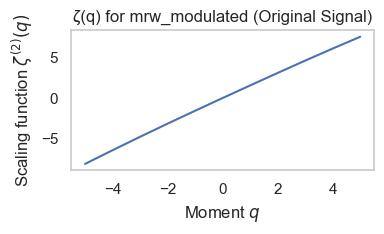

<Figure size 800x400 with 0 Axes>

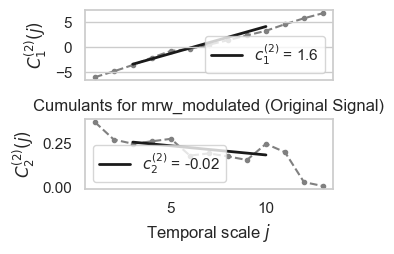

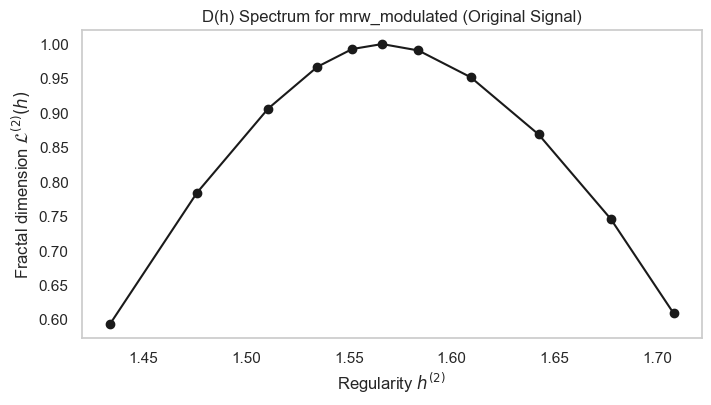

Loaded modes shape: (9, 82500) for mrw_modulated / EMD


<Figure size 800x400 with 0 Axes>

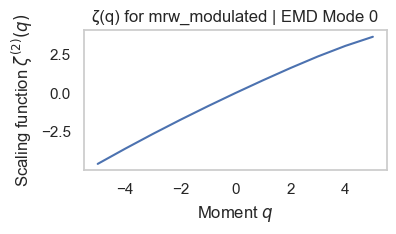

<Figure size 800x400 with 0 Axes>

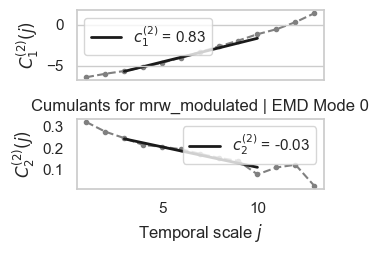

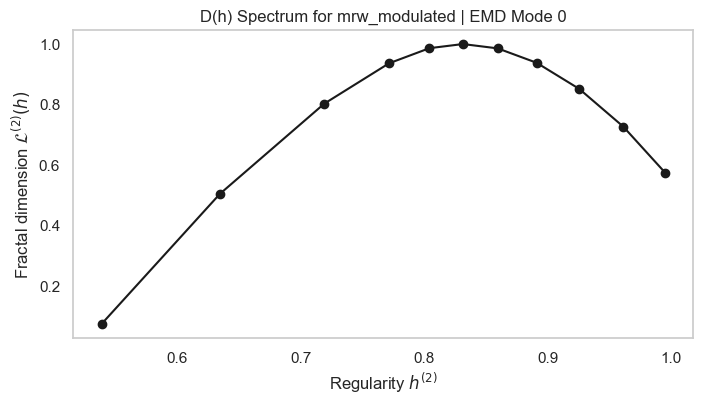

<Figure size 800x400 with 0 Axes>

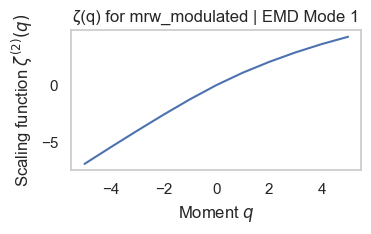

<Figure size 800x400 with 0 Axes>

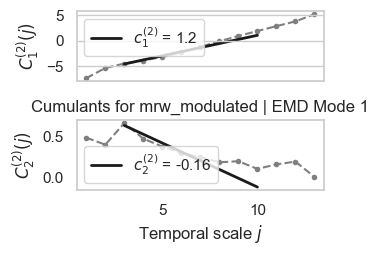

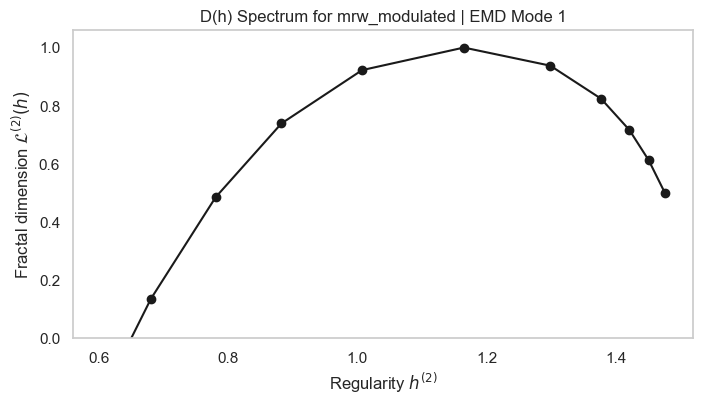

<Figure size 800x400 with 0 Axes>

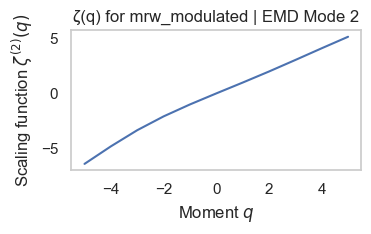

<Figure size 800x400 with 0 Axes>

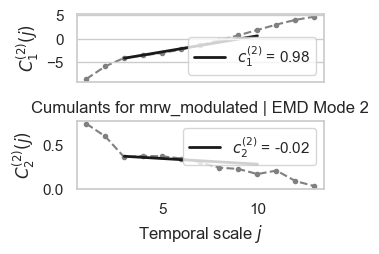

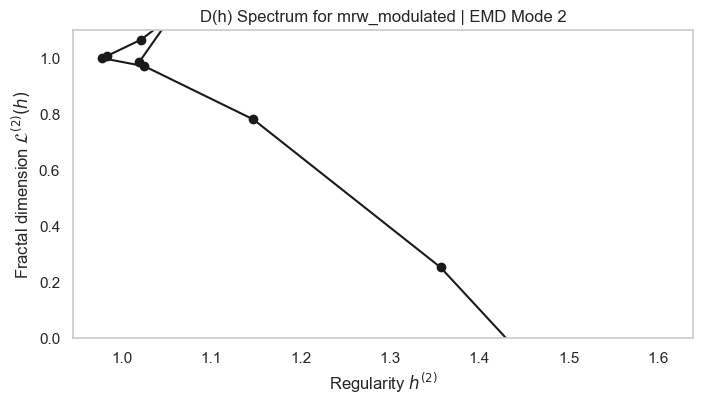

<Figure size 800x400 with 0 Axes>

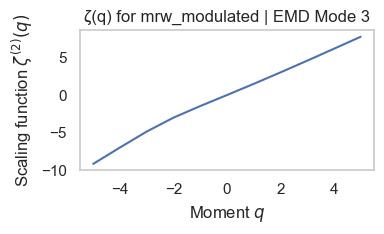

<Figure size 800x400 with 0 Axes>

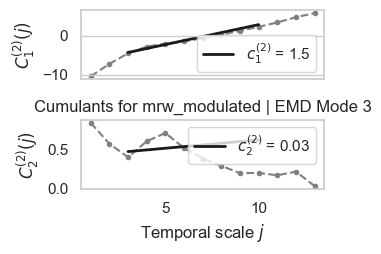

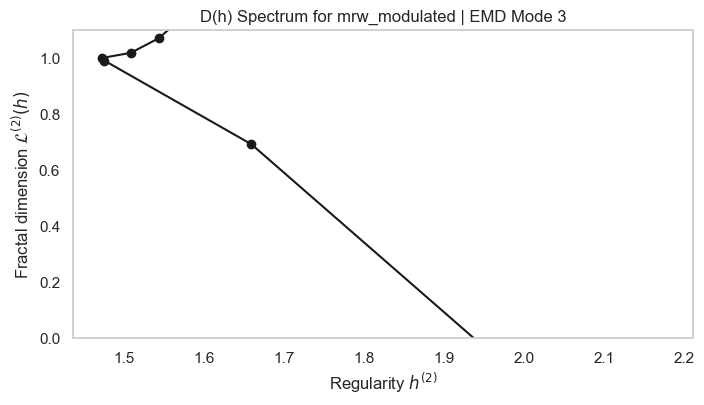

<Figure size 800x400 with 0 Axes>

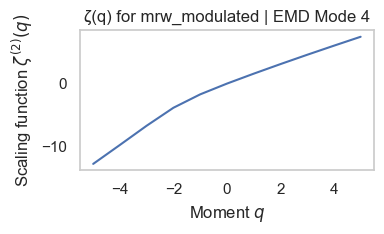

<Figure size 800x400 with 0 Axes>

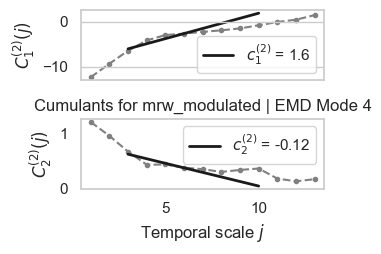

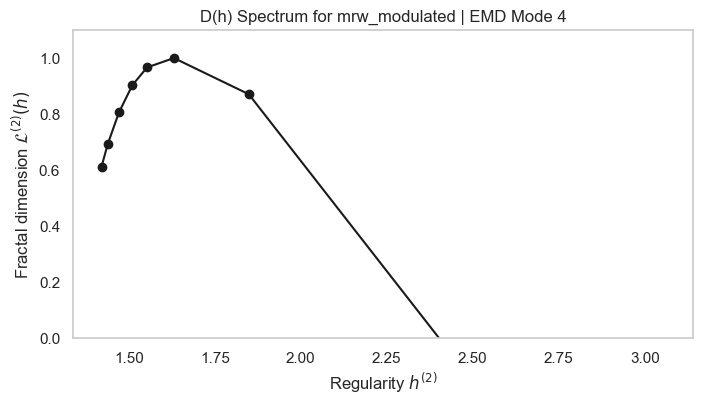

<Figure size 800x400 with 0 Axes>

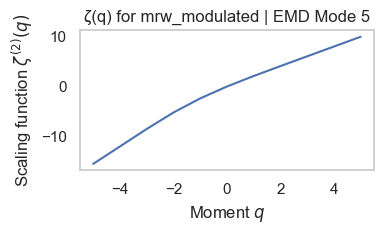

<Figure size 800x400 with 0 Axes>

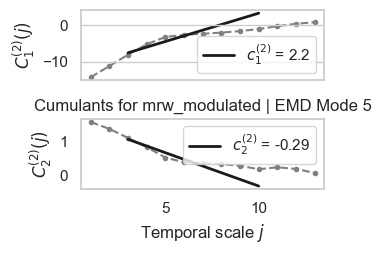

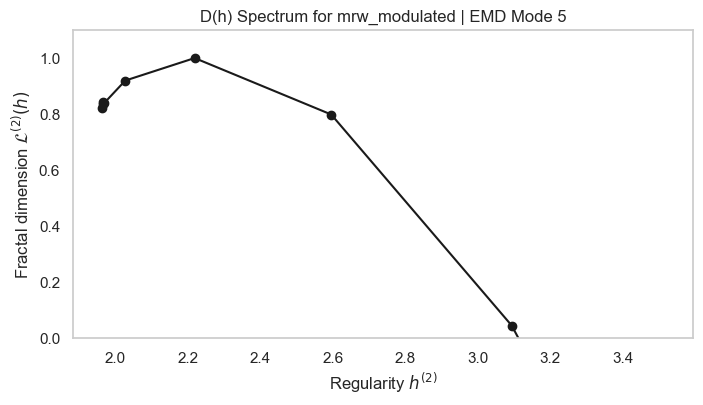

<Figure size 800x400 with 0 Axes>

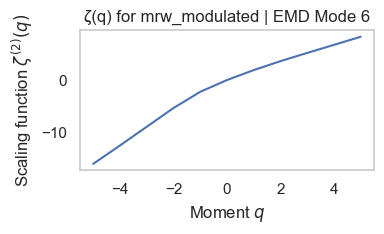

<Figure size 800x400 with 0 Axes>

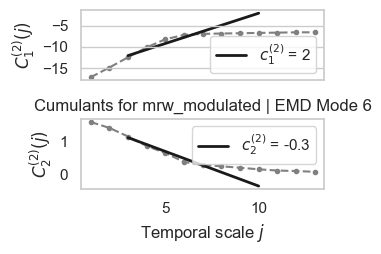

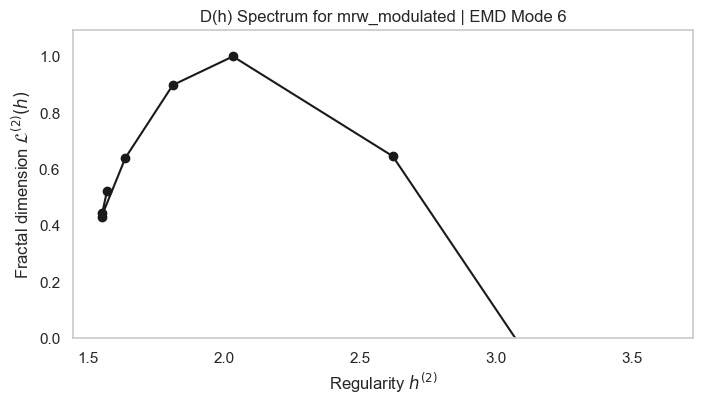

<Figure size 800x400 with 0 Axes>

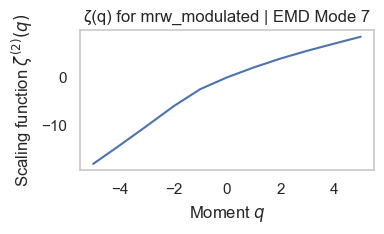

<Figure size 800x400 with 0 Axes>

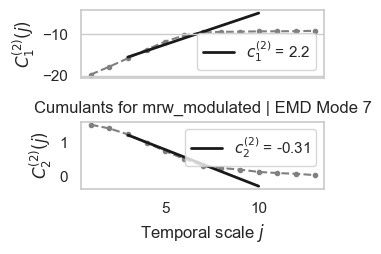

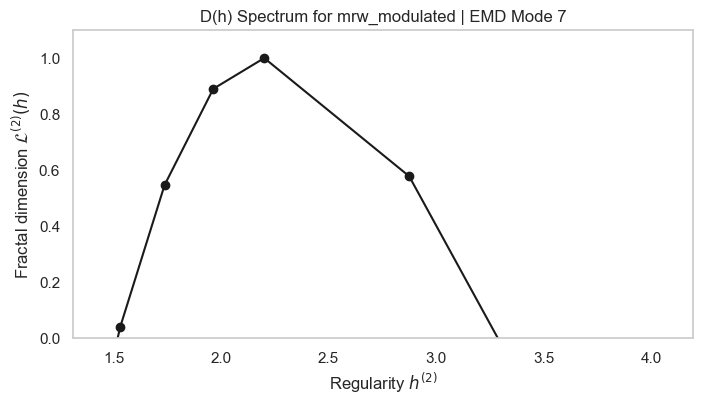

<Figure size 800x400 with 0 Axes>

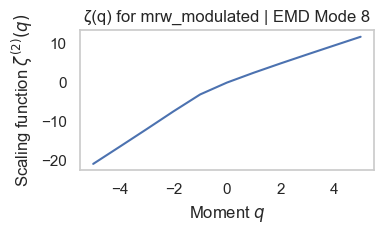

<Figure size 800x400 with 0 Axes>

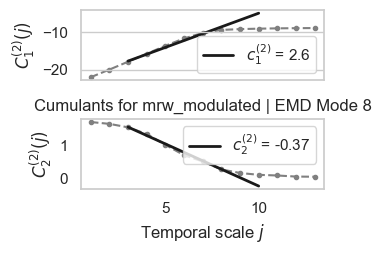

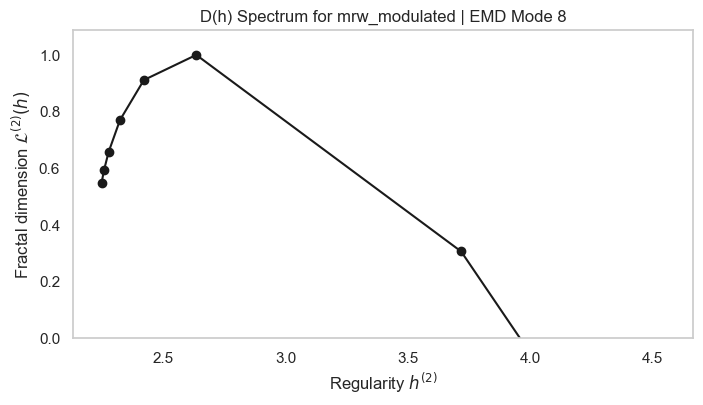

Processing signal: mrw_with_fbm


<Figure size 800x400 with 0 Axes>

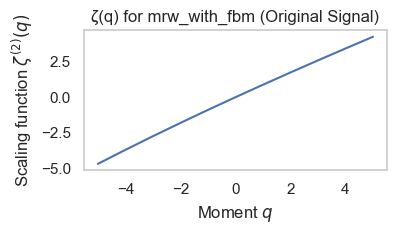

<Figure size 800x400 with 0 Axes>

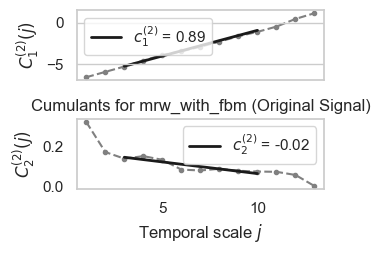

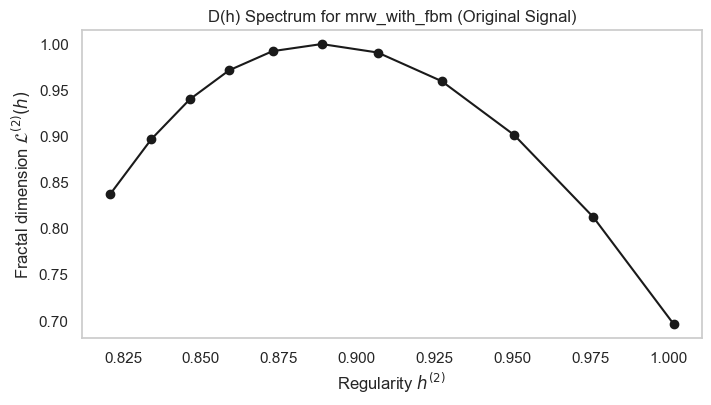

Loaded modes shape: (9, 82500) for mrw_with_fbm / EMD


<Figure size 800x400 with 0 Axes>

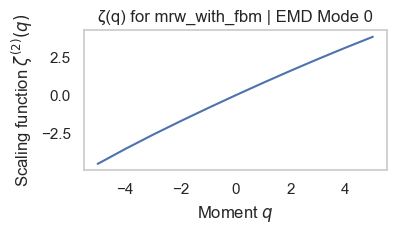

<Figure size 800x400 with 0 Axes>

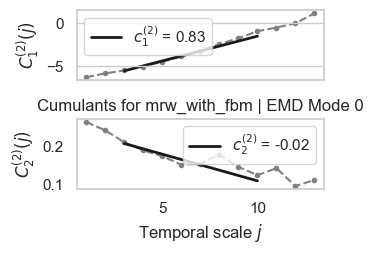

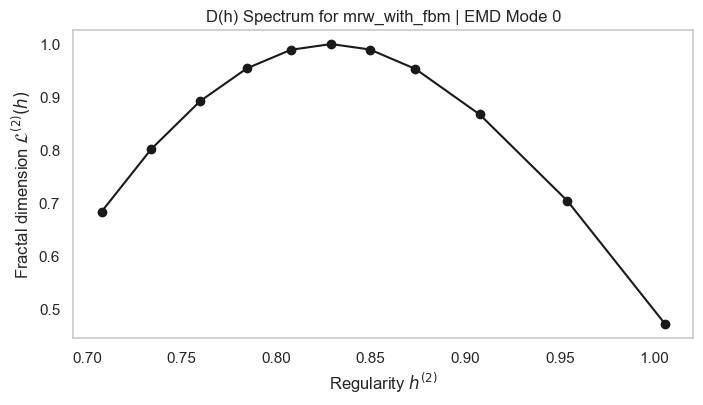

<Figure size 800x400 with 0 Axes>

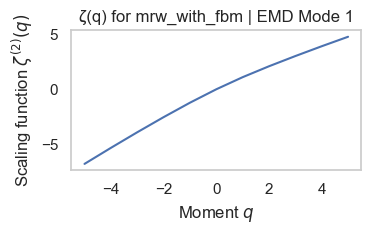

<Figure size 800x400 with 0 Axes>

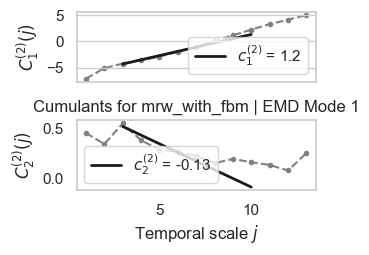

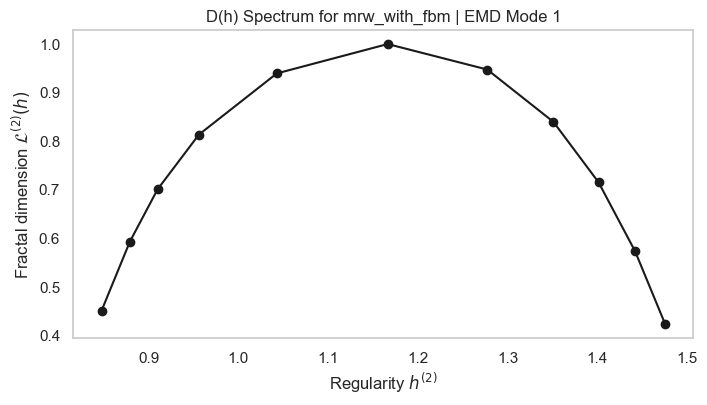

<Figure size 800x400 with 0 Axes>

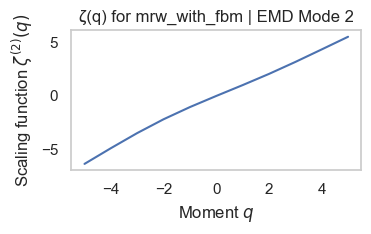

<Figure size 800x400 with 0 Axes>

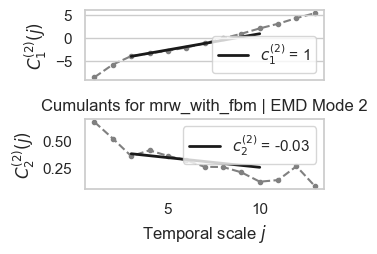

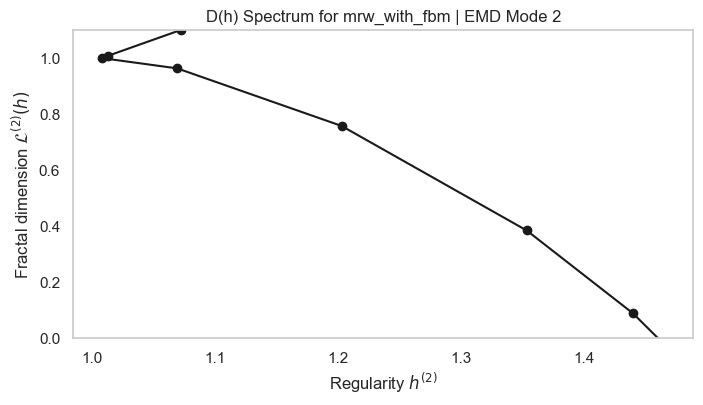

<Figure size 800x400 with 0 Axes>

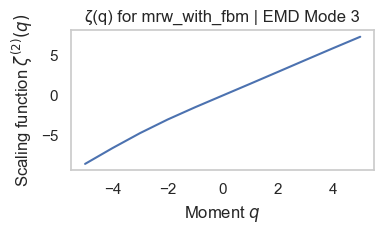

<Figure size 800x400 with 0 Axes>

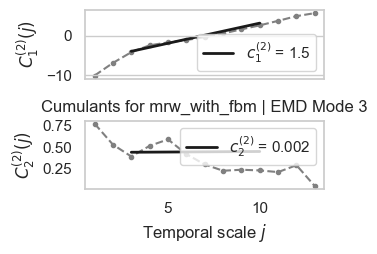

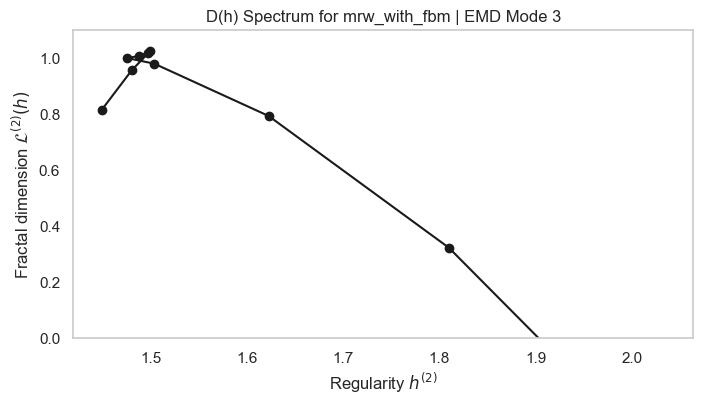

<Figure size 800x400 with 0 Axes>

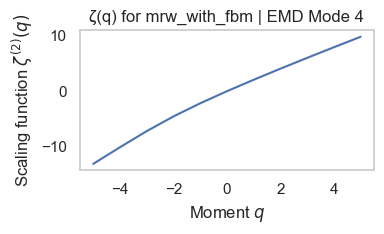

<Figure size 800x400 with 0 Axes>

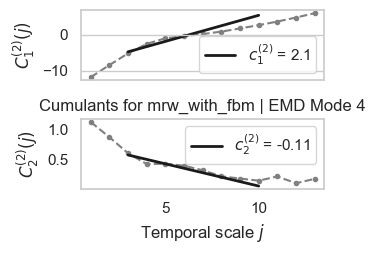

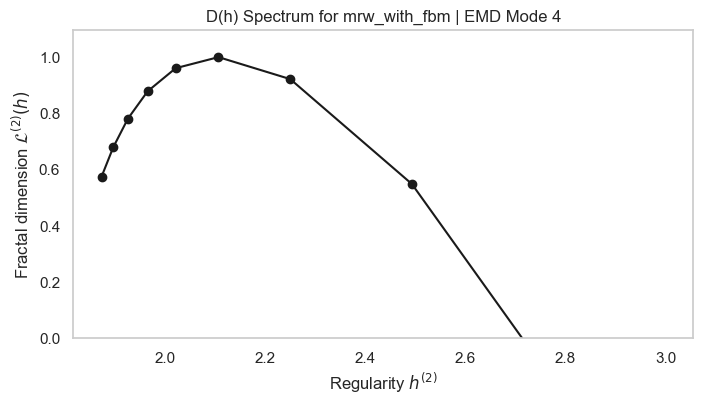

<Figure size 800x400 with 0 Axes>

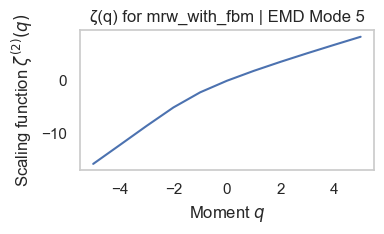

<Figure size 800x400 with 0 Axes>

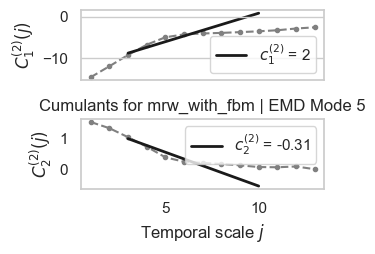

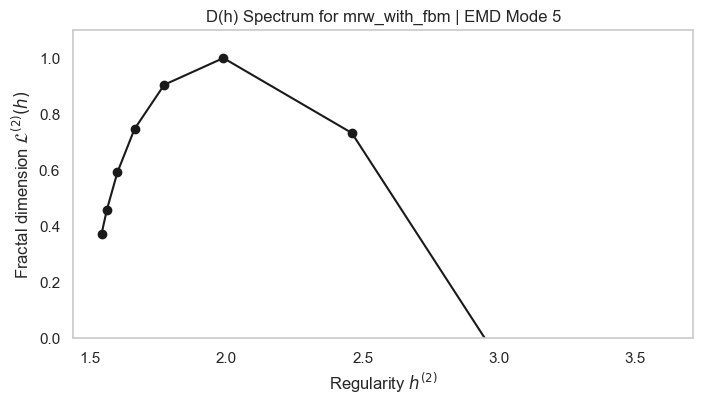

<Figure size 800x400 with 0 Axes>

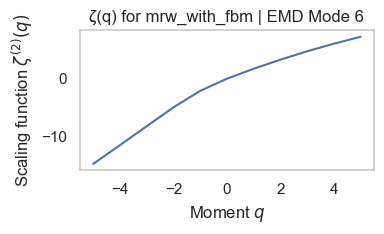

<Figure size 800x400 with 0 Axes>

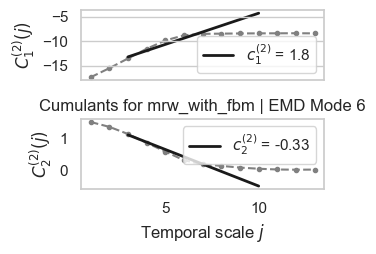

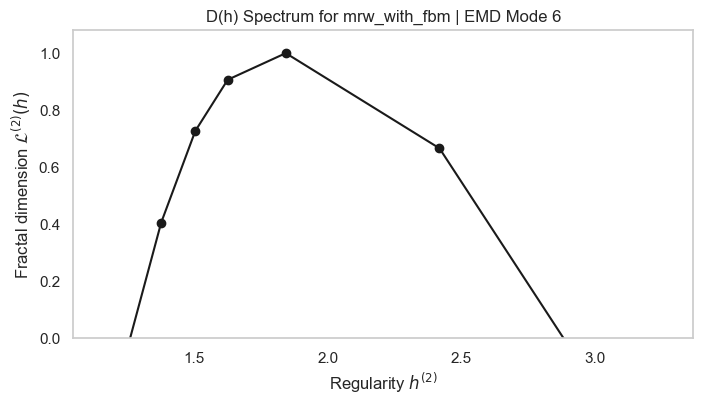

<Figure size 800x400 with 0 Axes>

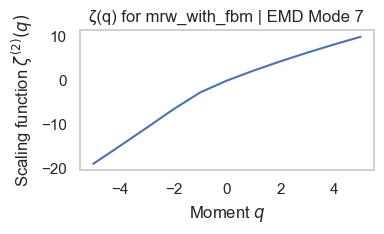

<Figure size 800x400 with 0 Axes>

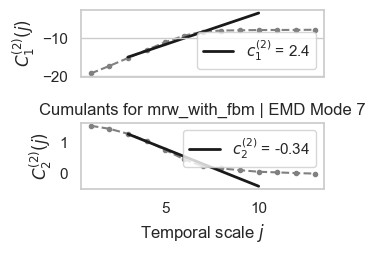

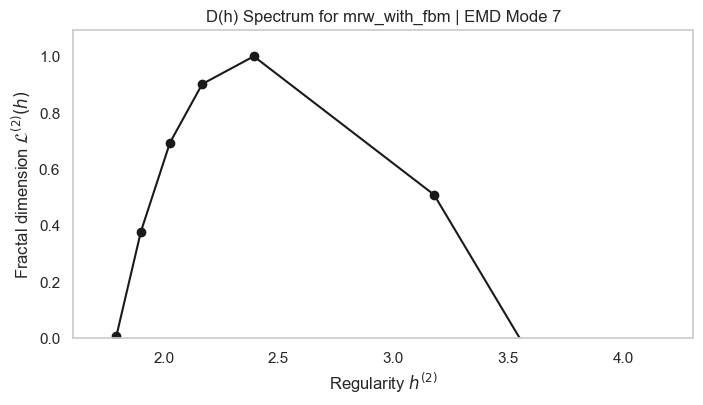

<Figure size 800x400 with 0 Axes>

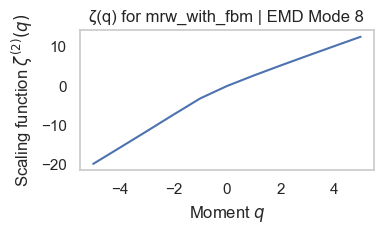

<Figure size 800x400 with 0 Axes>

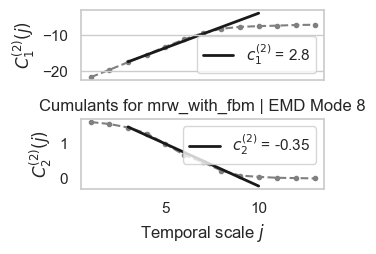

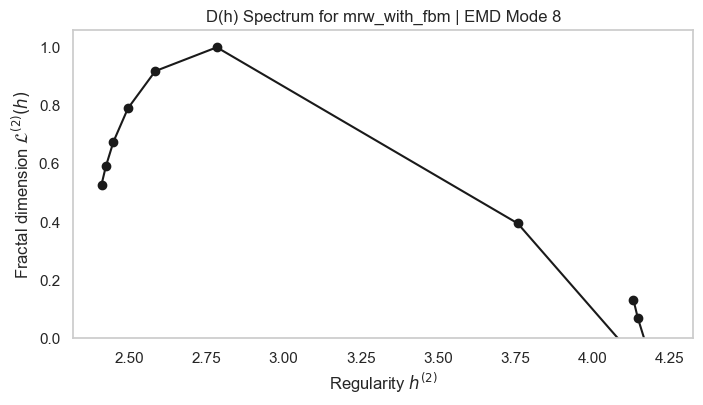

In [ ]:
scaling_ranges = [(3, 10)]  
q_vals = np.arange(-5, 6)
summary_records = []
methods = ["VMD","EMD"]

for signal, name in zip(signal_list, signal_names):
    if name is not "pure":
        print(f"Processing signal: {name}")

        # Apply MFA on original signal
        pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
        plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")

        # Collect cumulants summary for original signal
        summary_records.append({
            "Signal": name,
            "Mode": "Original",
            "Log-cumulant 1": pwt_signal.cumulants.values[0],
            "Log-cumulant 2": pwt_signal.cumulants.values[1]
        })

        for method in methods:
            modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")

            if not os.path.exists(modes_path):
                print(f"Modes not found for {name} / {method} at {modes_path}")
                continue

            modes = np.load(modes_path)
            print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

            for idx, mode in enumerate(modes):
                pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
                plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
                summary_records.append({
                    "Signal": name,
                    "Mode": f"{method} Mode {idx}",
                    "Log-cumulant 1": pwt_mode.cumulants.values[0],
                    "Log-cumulant 2": pwt_mode.cumulants.values[1]
                })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_records)
# Optionally save summary to CSV
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [285]:
summary_df

,Signal,Mode,Log-cumulant 1,Log-cumulant 2
0,mrw_modulated,Original,"[[[-6.050951192045323]], [[-4.869291744163444]...","[[[0.3754694417653184]], [[0.2748661861780022]..."
1,mrw_modulated,VMD Mode 0,"[[[-11.211981734925917]], [[-10.32882836126910...","[[[0.469651161529697]], [[0.2865180968069154]]..."
2,mrw_modulated,VMD Mode 1,"[[[-8.701741977959683]], [[-5.240603867277691]...","[[[0.4232220736968344]], [[0.36134007128224965..."
3,mrw_modulated,VMD Mode 2,"[[[-6.07942196033599]], [[-1.8174832643439647]...","[[[0.36553807869790234]], [[0.4500825059871349..."
4,mrw_modulated,VMD Mode 3,"[[[-4.63201284644294]], [[-2.2255850681399156]...","[[[0.44434847562509816]], [[0.3473592855931997..."
5,mrw_modulated,VMD Mode 4,"[[[-5.110731052107781]], [[-4.519424421303419]...","[[[0.5227717018995826]], [[0.2529838582282693]..."
6,mrw_with_fbm,Original,"[[[-6.574837400680047]], [[-5.933320739945995]...","[[[0.32119870051533184]], [[0.171098064963914]..."
7,mrw_with_fbm,VMD Mode 0,"[[[-11.508772703585533]], [[-9.923572522502251...","[[[0.2773634298863783]], [[0.2587066931698132]..."
8,mrw_with_fbm,VMD Mode 1,"[[[-6.657782588460689]], [[-2.569150351543657]...","[[[0.35594576963236335]], [[0.5478557343499055..."
9,mrw_with_fbm,VMD Mode 2,"[[[-5.920403866826006]], [[-2.570042820720065]...","[[[0.5077431906433603]], [[0.29799508819559417..."


In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PyEMD import EMD

# # Time axis
# fs = 1000
# t = np.linspace(0, 1, fs)

# # True components
# c1 = np.sin(2 * np.pi * 5 * t)
# c2 = np.sin(2 * np.pi * 20 * t)
# c3 = np.sin(2 * np.pi * 60 * t)
# signal = c1 + c2 + c3

# # EMD decomposition
# emd = EMD()
# imfs = emd.emd(signal, t)

# # Plot
# fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
# fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=14)

# axes[0].plot(t, signal, color='black')
# axes[0].set_ylabel("Original Signal")

# axes[1].plot(t, c1, label='5 Hz', linestyle='--')
# axes[1].plot(t, c2, label='20 Hz', linestyle='-.')
# axes[1].plot(t, c3, label='60 Hz', linestyle=':')
# axes[1].legend()
# axes[1].set_ylabel("True Components")

# for i in range(min(3, imfs.shape[0])):
#     axes[i+2].plot(t, imfs[i])
#     axes[i+2].set_ylabel(f"IMF {i+1}")

# axes[-1].set_xlabel("Time (s)")
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


In [ ]:
# Revoir l'optimisation du parametetre alpha, puis taus 
# Afficher les amplitudes des modes (afficher fréquences/amplitudes)
# Affichage des spectres en log 
# MFA sur la variation des amplitudes des modes et non sur les modes  => calcul la transformation en ondelette continue 
# kmeans sur les résultats des vrais données (séries + matrice de corréaltion) 
# Lancer la MVMD 
# Best/Worst en termes de MSE 


# Revoie la VMD entre espace temporelle et spectre de fourier 
# Comparer le nom des parametres entre la VMD code + VMD sur python 

In [8]:
from pywt import cwt, ContinuousWavelet

In [85]:
f = 10 / 250 * 2

In [86]:
f

0.08

In [87]:
wt = ContinuousWavelet('cmor.2-0.08')

In [88]:
import matplotlib.pyplot as plt

In [89]:
from pymultifracs.viz import plot_psd

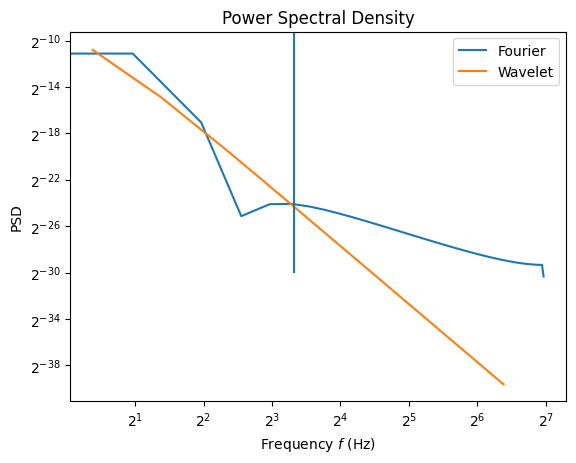

In [90]:
plot_psd(wt.wavefun(1, 2**10)[0].imag, 250)
plt.vlines(10, 2**-30, 2**-6)

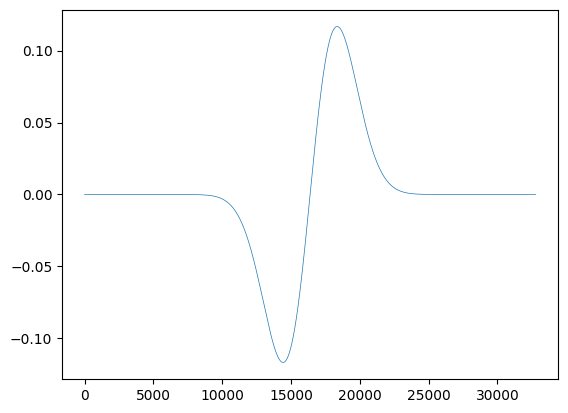

In [91]:
plt.plot(wt.wavefun(12, length=2**15)[0].imag, lw=.5)
# plt.plot(abs(wt.wavefun(11)[0]))